##  1. Importation des Bibliothèques

##  Configuration et Téléchargement des Données

**Important** : Cette cellule télécharge automatiquement le dataset depuis Google Drive.

Si vous exécutez ce notebook pour la première fois, le téléchargement prendra ~2-3 minutes.

In [ ]:

# TÉLÉCHARGEMENT AUTOMATIQUE DES DONNÉES

import os
import sys

# Installer gdown si nécessaire
try:
    import gdown
except ImportError:
    print('Installation de gdown...')
    !pip install -q gdown
    import gdown

# Vérifier si les données existent déjà
if os.path.exists('/content/dataset/Info.txt'):
    print('✅ Dataset déjà présent, passage à l\'étape suivante.')
else:
    print('📥 Téléchargement du dataset depuis Google Drive...')

    FILE_ID = '1KaUutsP6ofkN9d74PS7kqWMsbjyvt9I8'


    url = f'https://drive.google.com/uc?id={FILE_ID}'
    output = '/content/dataset.zip'

    try:
        gdown.download(url, output, quiet=False)
        !unzip -q {output} -d /content/
        print('Dataset prêt!')
    except Exception as e:
        print(f'❌ Erreur lors du téléchargement: {e}')
        print('   Vérifiez que le lien Drive est public et que l\'ID est correct.')
        sys.exit(1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import warnings
import os
import cv2
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score, roc_curve, auc)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
DATA_DIR = Path('/content/dataset')
IMAGE_DIR = DATA_DIR / 'all-mias'
CSV_PATH = DATA_DIR / 'info_labeled.csv'

## 2-Labelisation

In [ ]:
import pandas as pd

info_path = DATA_DIR / 'Info.txt'

records = []

with open(info_path, "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split()

        refnum = parts[0]
        bg = parts[1]

        if "NORM" in parts:
            abnormality = "NORM"
            severity = "N"
            x = y = radius = None

        else:
            abnormality = parts[2]
            severity = parts[3]
            if len(parts) >= 7:
                x = int(parts[4])
                y = int(parts[5])
                radius = int(parts[6])
            else:
                x = y = radius = None

        records.append({
            "REFNUM": refnum,
            "BG": bg,
            "CLASS": abnormality,
            "SEVERITY": severity,
            "X": x,
            "Y": y,
            "RADIUS": radius
        })

df = pd.DataFrame(records)
label_map = {"N": 0, "B": 1, "M": 2}
df["label"] = df["SEVERITY"].map(label_map)
label_name_map = {0: "Normal", 1: "Benign", 2: "Malignant"}
df["label_name"] = df["label"].map(label_name_map)

df.to_csv("/content/dataset/info_labeled.csv", index=False)
print("\nDataset prêt et sauvegardé dans info_labeled.csv")

print(f"Nombre total d'images: {len(df)}")
print(f"\nColonnes: {df.columns.tolist()}")
print(f"\n{df.head()}")
print(f"\nInfo du dataset:")
df.info()



Dataset prêt et sauvegardé dans info_labeled.csv
Nombre total d'images: 330

Colonnes: ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS', 'label', 'label_name']

   REFNUM BG CLASS SEVERITY      X      Y  RADIUS  label label_name
0  mdb001  G  CIRC        B  535.0  425.0   197.0      1     Benign
1  mdb002  G  CIRC        B  522.0  280.0    69.0      1     Benign
2  mdb003  D  NORM        N    NaN    NaN     NaN      0     Normal
3  mdb004  D  NORM        N    NaN    NaN     NaN      0     Normal
4  mdb005  F  CIRC        B  477.0  133.0    30.0      1     Benign

Info du dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   REFNUM      330 non-null    object 
 1   BG          330 non-null    object 
 2   CLASS       330 non-null    object 
 3   SEVERITY    330 non-null    object 
 4   X           119 non-null    float64
 5   Y       

# 3. Exploration des Données

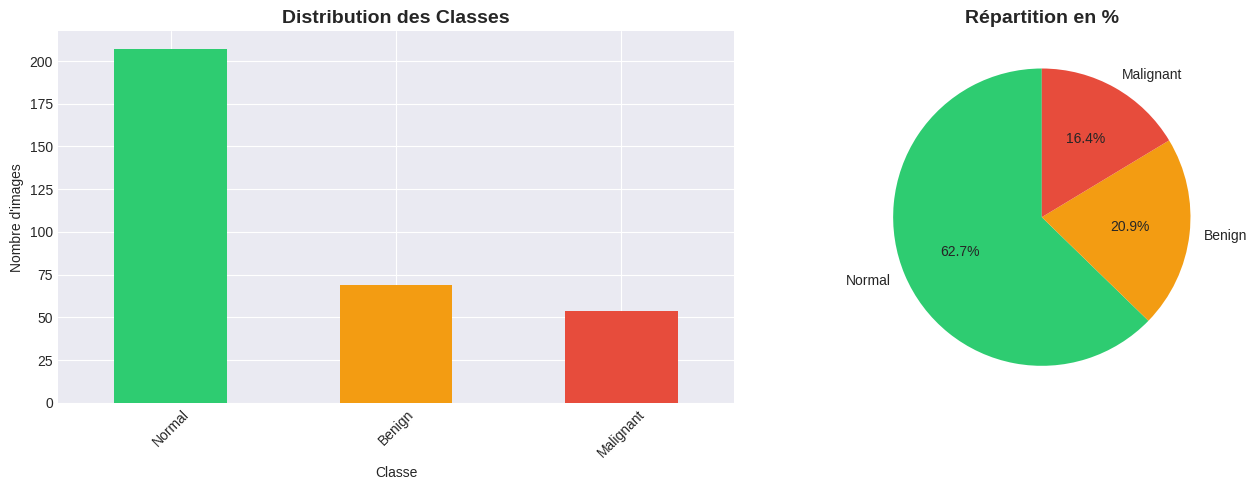


Statistiques par classe:
label_name
Benign        69
Malignant     54
Normal       207
dtype: int64


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['label_name'].value_counts().plot(kind='bar', ax=axes[0],
                                      color=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Nombre d\'images')
axes[0].tick_params(axis='x', rotation=45)


class_pct = df['label_name'].value_counts(normalize=True) * 100
axes[1].pie(class_pct, labels=class_pct.index, autopct='%1.1f%%',
            colors=['#2ecc71', '#f39c12', '#e74c3c'], startangle=90)
axes[1].set_title('Répartition en %', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nStatistiques par classe:")
print(df.groupby('label_name').size())

##  4. Visualisation d'Exemples d'Images

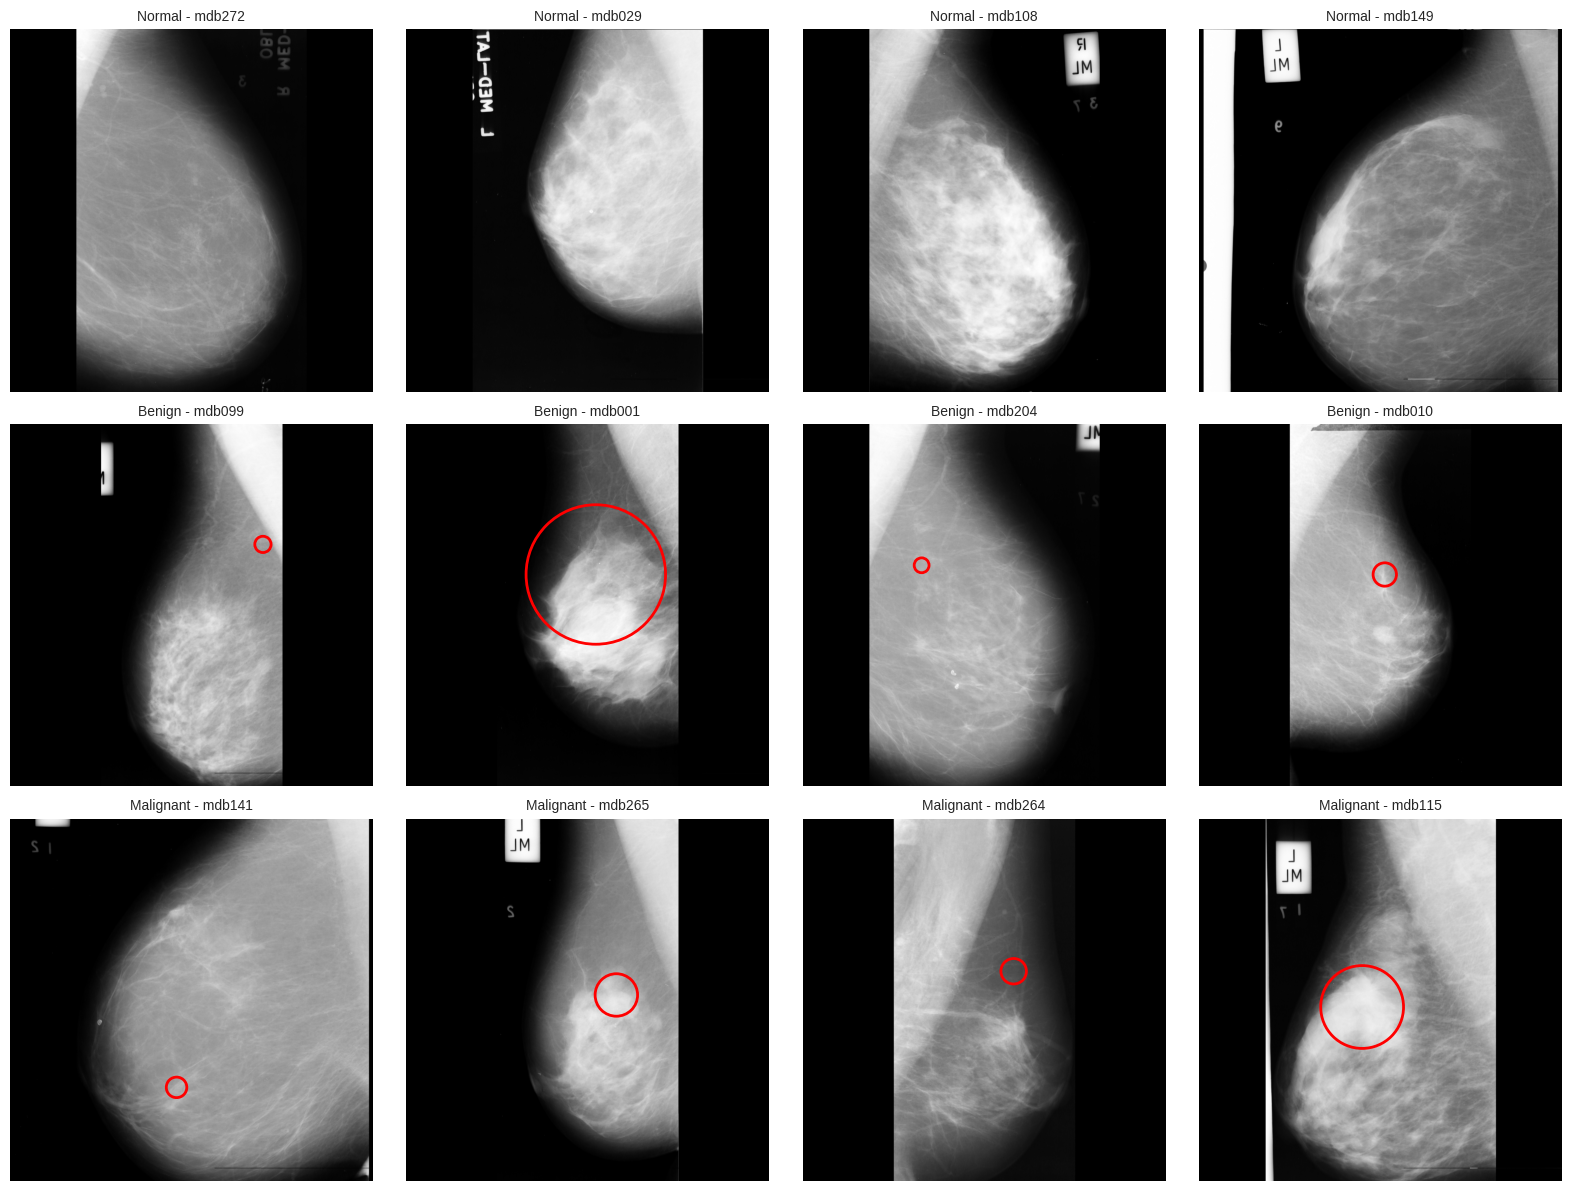

In [ ]:
CLASS_NAMES = ['Normal', 'Benign', 'Malignant']
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for label_idx, label_name in enumerate(CLASS_NAMES):
    samples = df[df['label_name'] == label_name].sample(n=4, random_state=42)
    for idx, (_, row) in enumerate(samples.iterrows()):
        img_path = IMAGE_DIR / f"{row['REFNUM']}.pgm"
        if not img_path.exists():
            img_path = IMAGE_DIR / f"{row['REFNUM']}.png"

        if img_path.exists():
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

            ax = axes[label_idx, idx]
            ax.imshow(img, cmap='gray')
            if not pd.isna(row['X']) and row['label'] != 0:
                circle = plt.Circle((row['X'], row['Y']), row['RADIUS'],
                                   color='red', fill=False, linewidth=2)
                ax.add_patch(circle)

            ax.set_title(f"{label_name} - {row['REFNUM']}", fontsize=10)
            ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
image_dir = IMAGE_DIR
info_csv = DATA_DIR / 'info_labeled.csv'
output_dir = "/content/MIAS/preprocessed/"
target_size = (224, 224)
os.makedirs(output_dir, exist_ok=True)
df = pd.read_csv(info_csv)

## 5.Traitement et visualisation d’exemples d’images avec et sans masse

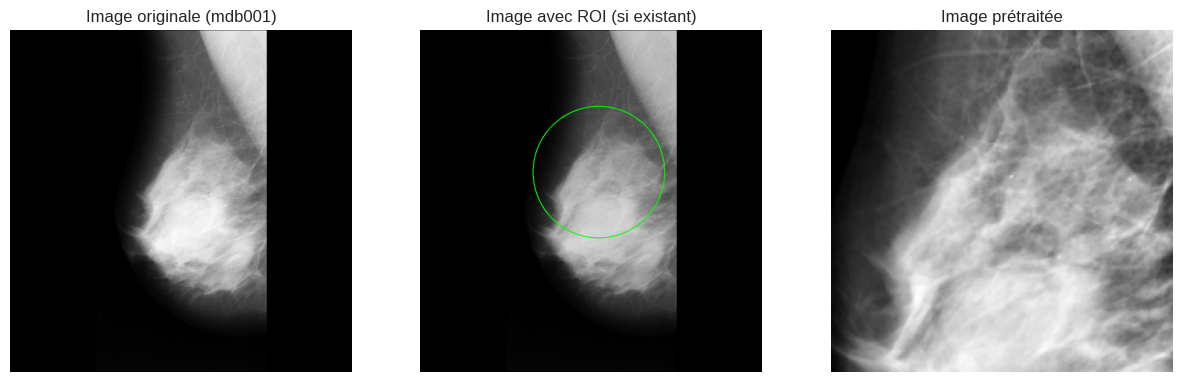

Shape image prétraitée pour mdb001 : (224, 224, 1)


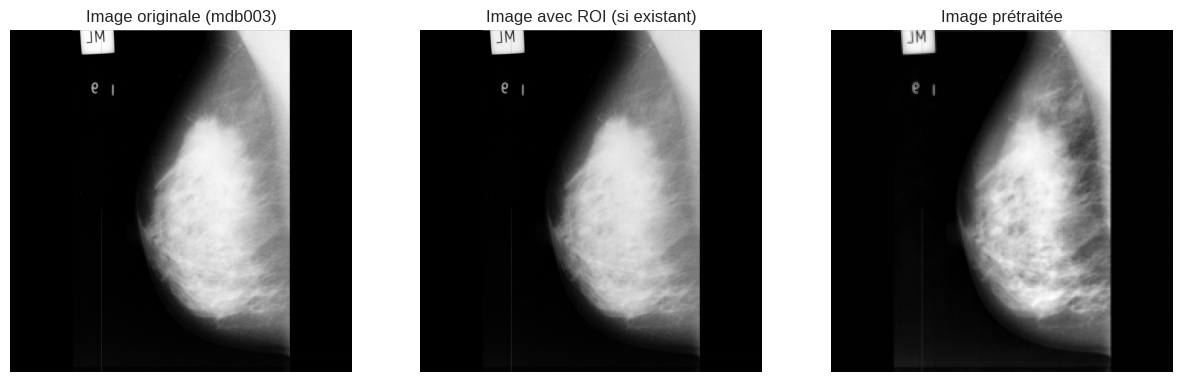

Shape image prétraitée pour mdb003 : (224, 224, 1)


In [ ]:
indices = [0, 2]

for idx in indices:
    row = df.iloc[idx]
    image_path = os.path.join(image_dir, row["REFNUM"] + ".pgm")

    if not os.path.exists(image_path):
        print(f"Image manquante : {row['REFNUM']}")
        continue

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Vérifier si ROI existe
    if pd.notna(row["X"]) and pd.notna(row["Y"]) and pd.notna(row["RADIUS"]):
        roi, roi_coords = preprocess_image(img, row["X"], row["Y"], row["RADIUS"], target_size=target_size)
        x1, y1, x2, y2 = roi_coords
        img_with_roi = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        x_center, y_center, radius = int(row["X"]), int(row["Y"]), int(row["RADIUS"])
        cv2.circle(img_with_roi, (x_center, y_center), radius, (0, 255, 0), 2)
    else:
        roi, roi_coords = preprocess_image(img, target_size=target_size)
        img_with_roi = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)


    # Affichage
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image originale ({row['REFNUM']})")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img_with_roi)
    plt.title("Image avec ROI (si existant)")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(roi.squeeze(), cmap='gray')
    plt.title("Image prétraitée")
    plt.axis('off')

    plt.show()

    print(f"Shape image prétraitée pour {row['REFNUM']} :", roi.shape)


## 6.Prétraitement avec modification des coordonnées

In [ ]:

output_dir = "/content/output/preprocessed_full_2/"
os.makedirs(output_dir, exist_ok=True)

target_size = (224, 224)

df = pd.read_csv(info_csv)

def preprocess_image_full(image, target_size=(224,224)):

    img = image.astype(np.float32) / 255.0

    img = cv2.GaussianBlur(img, (3,3), 0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = (clahe.apply((img*255).astype(np.uint8))).astype(np.float32) / 255.0

    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    img_resized = np.expand_dims(img_resized, axis=-1)

    return img_resized

for idx, row in df.iterrows():
    image_path = os.path.join(image_dir, row["REFNUM"] + ".pgm")

    if not os.path.exists(image_path):
        print(f"Image manquante : {row['REFNUM']}")
        continue

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    orig_h, orig_w = img.shape

    img_preprocessed = preprocess_image_full(img, target_size=target_size)

    scale_x = target_size[1] / orig_w
    scale_y = target_size[0] / orig_h

    if not np.isnan(row["X"]) and not np.isnan(row["Y"]) and not np.isnan(row["RADIUS"]):
        new_x = int(row["X"] * scale_x)
        new_y = int(row["Y"] * scale_y)
        new_radius = int(row["RADIUS"] * (scale_x + scale_y)/2)

        df.at[idx, "X"] = new_x
        df.at[idx, "Y"] = new_y
        df.at[idx, "RADIUS"] = new_radius

    save_path = os.path.join(output_dir, row["REFNUM"] + ".png")
    cv2.imwrite(save_path, (img_preprocessed.squeeze()*255).astype(np.uint8))

updated_csv_path = "/content/info_labeled_resized.csv"
df.to_csv(updated_csv_path, index=False)

print("Prétraitement complet et mise à jour des coordonnées terminé ")
print(f"CSV mis à jour sauvegardé ici : {updated_csv_path}")


Prétraitement complet et mise à jour des coordonnées terminé ✅
CSV mis à jour sauvegardé ici : /content/info_labeled_resized.csv


Split Data

In [ ]:


image_dir_preprocessed = "/content/output/preprocessed_full_2/"

base_dir = "/content/output/dataset_split_simple_2/"
for split in ["train","val","test"]:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

df = pd.read_csv(info_csv)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])
val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
def copy_and_load_simple(df_subset, split_name):
    X = []
    y = []
    for idx, row in df_subset.iterrows():
        src = os.path.join(image_dir_preprocessed, row["REFNUM"] + ".png")
        dst = os.path.join(base_dir, split_name, row["REFNUM"] + ".png")  # même nom
        if os.path.exists(src):
            shutil.copy(src, dst)
            # Lire image pour array
            img = cv2.imread(src, cv2.IMREAD_GRAYSCALE)
            img = img.astype(np.float32)/255.0

            img = np.expand_dims(img, axis=-1)
            X.append(img)
            y.append(row["label"])
    return np.array(X), np.array(y)
X_train, y_train = copy_and_load_simple(train_df, "train")

X_val, y_val = copy_and_load_simple(val_df, "val")

X_test, y_test = copy_and_load_simple(test_df, "test")

print(" Split terminé !")
print("Train :", X_train.shape, y_train.shape)
print("Validation :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)
print(f"Dossiers créés dans : {base_dir}")


✅ Split terminé !
Train : (231, 224, 224, 1) (231,)
Validation : (49, 224, 224, 1) (49,)
Test : (50, 224, 224, 1) (50,)
Dossiers créés dans : /content/drive/MyDrive/MIAS/dataset_split_simple_2/


## 7.Extraction de patches

In [ ]:
image_dir = "/content/output/preprocessed_full_2/"
base_dir = "/content/output/dataset_split_patches/"

patch_size = (224,224)
stride = 112  # chevauchement 50%
apply_clahe = True

for split in ["train_patches","val_patches","test_patches"]:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)


df = pd.read_csv(info_csv)

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])
val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])

def extract_patches(img, patch_size=(224,224), stride=112):
    patches = []
    h, w = img.shape[:2]
    ph, pw = patch_size

    for y in range(0, h - ph + 1, stride):
        for x in range(0, w - pw + 1, stride):
            patch = img[y:y+ph, x:x+pw]
            patches.append(patch)
    return patches

def create_and_save_patches(df_subset, split_name, base_dir):
    X_patches = []
    y_patches = []
    patch_records = []

    save_dir = os.path.join(base_dir, split_name)

    for idx, row in df_subset.iterrows():
        img_path = os.path.join(image_dir_preprocessed, row["REFNUM"] + ".png")
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if apply_clahe:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)
        img = img.astype(np.float32)/255.0
        img = np.stack([img]*3, axis=-1)

        patches = extract_patches(img, patch_size=patch_size, stride=stride)

        for p_idx, patch in enumerate(patches):
            # Enregistrer le patch
            patch_filename = f"{row['REFNUM']}_{p_idx}.png"
            cv2.imwrite(os.path.join(save_dir, patch_filename), (patch[:,:,0]*255).astype(np.uint8))

            # Ajouter aux arrays numpy
            X_patches.append(patch)
            y_patches.append(row["label"])

            # Ajouter au CSV
            patch_records.append({
                "patch_id": patch_filename,
                "parent_image": row["REFNUM"],
                "label": row["label"]
            })

    # Créer dataframe pour les patches
    patch_df = pd.DataFrame(patch_records)
    patch_df.to_csv(os.path.join(base_dir, f"{split_name}_patches_labels.csv"), index=False)

    return np.array(X_patches, dtype=np.float32), np.array(y_patches, dtype=np.int32)

# Créer les patches pour train/val/test
X_train_patches, y_train_patches = create_and_save_patches(train_df, "train_patches", base_dir)
X_val_patches, y_val_patches     = create_and_save_patches(val_df, "val_patches", base_dir)
X_test_patches, y_test_patches   = create_and_save_patches(test_df, "test_patches", base_dir)

# Vérification
print("Patches créés et enregistrés !")
print("Train patches :", X_train_patches.shape, y_train_patches.shape)
print("Val patches   :", X_val_patches.shape, y_val_patches.shape)
print("Test patches  :", X_test_patches.shape, y_test_patches.shape)
print(f"Patches enregistrés dans : {base_dir}")


✅ Patches créés et enregistrés !
Train patches : (231, 224, 224, 3) (231,)
Val patches   : (49, 224, 224, 3) (49,)
Test patches  : (50, 224, 224, 3) (50,)
Patches enregistrés dans : /content/drive/MyDrive/MIAS/dataset_split_patches/


## 8.Augmentation

In [ ]:

image_dir ="/content/output/dataset_split_simple/train"
aug_dir = "/content/output/dataset_split_simple/trainAugmentetd"
os.makedirs(aug_dir, exist_ok=True)
augment_times = 5
os.makedirs(aug_dir, exist_ok=True)

df = pd.read_csv(info_csv)

def augment_preprocessed_image(img_path, augment_times=5, save_dir=None):

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Impossible de lire l'image : {img_path}")
        return []


    img = img.astype(np.float32)/255.0
    img = np.expand_dims(img, axis=(0,-1))

    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    gen = datagen.flow(img, batch_size=1)
    augmented_images = []

    for i in range(augment_times):
        batch = next(gen)
        aug_img = batch[0].squeeze()
        augmented_images.append(aug_img)

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{os.path.splitext(os.path.basename(img_path))[0]}.png")
            cv2.imwrite(save_path, (aug_img*255).astype(np.uint8))

    return augmented_images

for idx, row in df.iterrows():
    img_name = row["REFNUM"] + ".png"
    img_path = os.path.join(image_dir, img_name)
    print(f"Augmentation : {img_name} ({idx+1}/{len(df)})")
    augment_preprocessed_image(img_path, augment_times=augment_times, save_dir=aug_dir)

print(" Augmentation terminée pour toutes les images")

Augmentation : mdb001.png (1/330)
Augmentation : mdb002.png (2/330)
Augmentation : mdb003.png (3/330)
Augmentation : mdb004.png (4/330)
Impossible de lire l'image : /content/drive/MyDrive/MIAS/dataset_split_simple/train/mdb004.png
Augmentation : mdb005.png (5/330)
Augmentation : mdb005.png (6/330)
Augmentation : mdb006.png (7/330)
Augmentation : mdb007.png (8/330)
Augmentation : mdb008.png (9/330)
Augmentation : mdb009.png (10/330)
Augmentation : mdb010.png (11/330)
Impossible de lire l'image : /content/drive/MyDrive/MIAS/dataset_split_simple/train/mdb010.png
Augmentation : mdb011.png (12/330)
Augmentation : mdb012.png (13/330)
Impossible de lire l'image : /content/drive/MyDrive/MIAS/dataset_split_simple/train/mdb012.png
Augmentation : mdb013.png (14/330)
Augmentation : mdb014.png (15/330)
Impossible de lire l'image : /content/drive/MyDrive/MIAS/dataset_split_simple/train/mdb014.png
Augmentation : mdb015.png (16/330)
Augmentation : mdb016.png (17/330)
Impossible de lire l'image : /cont

## 9.Pipeline Multi‑Task CNN MIAS – Version Classique

In [ ]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 8
base_dir = "/content/output/dataset_split_simple_2/"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")
df = pd.read_csv(info_csv)

df['REFNUM'] = df['REFNUM'].str.strip()
df['label'] = df['label'].astype(int)

df['X'] = df['X'].fillna(0).astype(float)
df['Y'] = df['Y'].fillna(0).astype(float)
df['RADIUS'] = df['RADIUS'].fillna(0).astype(float)

print(f"Distribution des labels dans le CSV:")
print(df['label'].value_counts().sort_index())


def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Impossible de charger l'image: {img_path}")
    img = img.astype(np.float32) / 255.0
    img = np.stack([img] * 3, axis=-1)
    return img
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

def generator(df_subset, split_name, augment=False):
    for _, row in df_subset.iterrows():
        img_name = row["REFNUM"] + ".png"
        img_path = os.path.join(base_dir, split_name, img_name)

        if not os.path.exists(img_path):
            continue

        try:
            img = load_image(img_path)
        except Exception as e:
            print(f"Erreur lors du chargement de {img_path}: {e}")
            continue
        if augment:
            img = train_datagen.random_transform(img)

        # TASK 1: Détection binaire (0 = Normal, 1 = Masse présente)
        label = int(row["label"])
        detection = 0.0 if label == 0 else 1.0

        # TASK 2: Classification (Normal/Benign/Malignant)
        classification = tf.keras.utils.to_categorical(label, num_classes=NUM_CLASSES)

        # TASK 3: Localisation
        if detection == 1.0:

            x = float(row['X']) / 1024.0
            y = float(row['Y']) / 1024.0
            r = float(row['RADIUS']) / 1024.0

            localization = [x, y, 2*r, 2*r]
        else:
            localization = [0.0, 0.0, 0.0, 0.0]

        yield img, {
            "detection": np.array(detection, dtype=np.float32),
            "classification": np.array(classification, dtype=np.float32),
            "localization": np.array(localization, dtype=np.float32)
        }


def create_dataset(df_subset, split_name, augment=False, shuffle=False, repeat=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator(df_subset, split_name, augment=augment),
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            {
                "detection": tf.TensorSpec(shape=(), dtype=tf.float32),
                "classification": tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.float32),
                "localization": tf.TensorSpec(shape=(4,), dtype=tf.float32)
            }
        )
    )

    # Répéter le dataset pour éviter l'arrêt prématuré
    if repeat:
        dataset = dataset.repeat()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Filtrer les DataFrames par split
train_files = [f.replace('.png', '') for f in os.listdir(train_dir) if f.endswith('.png')]
val_files = [f.replace('.png', '') for f in os.listdir(val_dir) if f.endswith('.png')]
test_files = [f.replace('.png', '') for f in os.listdir(test_dir) if f.endswith('.png')]

df_train = df[df["REFNUM"].isin(train_files)].reset_index(drop=True)
df_val = df[df["REFNUM"].isin(val_files)].reset_index(drop=True)
df_test = df[df["REFNUM"].isin(test_files)].reset_index(drop=True)

print(f"\nNombre d'images - Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")
print(f"\n Distribution TRAIN:")
print(df_train['label'].value_counts().sort_index())
print(f"\n Distribution VAL:")
print(df_val['label'].value_counts().sort_index())
print(f"\n Distribution TEST:")
print(df_test['label'].value_counts().sort_index())

# Calculer le déséquilibre
train_normal = (df_train['label'] == 0).sum()
train_abnormal = (df_train['label'] != 0).sum()
print(f"\n Ratio Normal/Anormal dans TRAIN: {train_normal}/{train_abnormal} = {train_normal/train_abnormal:.2f}:1")

print("\n" + "="*50)
print("VÉRIFICATION DES DONNÉES")
print("="*50)

# Tester le générateur
test_gen = generator(df_train.head(3), "train", augment=False)
for i, (img, labels) in enumerate(test_gen):
    print(f"\nImage {i+1}:")
    print(f"  Shape: {img.shape}")
    print(f"  Min/Max: {img.min():.3f} / {img.max():.3f}")
    print(f"  Detection: {labels['detection']}")
    print(f"  Classification: {labels['classification']}")
    print(f"  Localization: {labels['localization']}")
    if i >= 2:
        break

print("\n Génération des données OK")
print("="*50)

# Créer les datasets avec augmentation pour train
train_dataset = create_dataset(df_train, "train", augment=True, shuffle=True, repeat=True)
val_dataset = create_dataset(df_val, "val", augment=False, shuffle=False, repeat=True)
test_dataset = create_dataset(df_test, "test", augment=False, shuffle=False, repeat=False)
# Modèle Multi-Task avec ResNet50
def build_multitask_model():
    """Construit le modèle multi-task avec régularisation forte"""
    inputs = layers.Input(shape=(224, 224, 3), name="input_image")

    # Backbone: ResNet50 pré-entraîné
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze pour commencer

    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Dropout plus fort contre overfitting

    # HEAD 1: Détection binaire (masse présente ou non)
    det = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    det = layers.Dropout(0.5)(det)
    det = layers.Dense(64, activation="relu")(det)
    det = layers.Dropout(0.3)(det)
    output_detection = layers.Dense(1, activation="sigmoid", name="detection")(det)

    # HEAD 2: Classification (Normal/Benign/Malignant)
    cls = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    cls = layers.Dropout(0.5)(cls)
    cls = layers.Dense(64, activation="relu")(cls)
    cls = layers.Dropout(0.3)(cls)
    output_classification = layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(cls)

    # HEAD 3: Localisation (bounding box)
    loc = layers.Dense(128, activation="relu")(x)
    loc = layers.Dropout(0.4)(loc)
    output_localization = layers.Dense(4, activation="sigmoid", name="localization")(loc)

    model = models.Model(
        inputs=inputs,
        outputs=[output_detection, output_classification, output_localization]
    )

    return model, base_model

model, base_model = build_multitask_model()
model.summary()

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=df_train['label'].values
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}

print(f"\n Poids de classes calculés:")
print(f"  Normal (0):    {class_weights[0]:.2f}")
print(f"  Benign (1):    {class_weights[1]:.2f}")
print(f"  Malignant (2): {class_weights[2]:.2f}")

# FOCAL LOSS pour detection
def focal_loss(gamma=1.5, alpha=0.65):

    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Focal Loss formula
        y_true = tf.cast(y_true, tf.float32)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)

        return weight * cross_entropy

    return focal_loss_fixed

losses = {
    "detection": focal_loss(gamma=1.5, alpha=0.65),
    "classification": "categorical_crossentropy",
    "localization": "mse"
}

loss_weights = {
    "detection": 1.5,
    "classification": 2.5,
    "localization": 0.2
}

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        "detection": ["accuracy", tf.keras.metrics.AUC(name="auc"),
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")],
        "classification": ["accuracy"]
    }
)



#  Callbacks améliorés

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_detection_auc',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_detection_auc',   # Surveiller AUC
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/output/best_model_phase1.keras',  # Format natif
        monitor='val_detection_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]


#  PHASE 1: Feature Extraction (Backbone gelé)

print("\n" + "="*50)
print("PHASE 1: Feature Extraction")
print("="*50)

# Calculer les steps CORRECTEMENT
train_steps = max(1, len(df_train) // BATCH_SIZE)
val_steps = max(1, len(df_val) // BATCH_SIZE)

print(f"Train steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

# Créer des sample_weights pour la classification
def create_sample_weights(df_subset):
    weights = []
    for label in df_subset['label'].values:
        weights.append(class_weight_dict[label])
    return np.array(weights)

# Note: TensorFlow multi-output ne supporte pas directement sample_weight par output
# On utilisera class_weight dans le fit à la place
print(f"\n Utilisation de class_weight pour équilibrer l'apprentissage")

history1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,  # Plus d'epochs pour convergence
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

# PHASE 2: Fine-Tuning (Dégeler les dernières couches
print("\n" + "="*50)
print("PHASE 2: Fine-Tuning")
print("="*50)

base_model.trainable = True

# Geler seulement les premières couches
for layer in base_model.layers[:-50]:
    layer.trainable = False

print(f"Nombre de couches entraînables: {len([l for l in base_model.layers if l.trainable])}")

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        "detection": ["accuracy", tf.keras.metrics.AUC(name="auc"),
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")],
        "classification": ["accuracy"]
    }
)

history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Plus d'epochs
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

# Évaluation finale sur le test set

print("\n" + "="*50)
print("ÉVALUATION FINALE SUR TEST SET")
print("="*50)

# Pour test, on ne veut pas repeat donc recréer sans repeat
test_dataset_eval = create_dataset(df_test, "test", augment=False, shuffle=False, repeat=False)
test_steps = max(1, len(df_test) // BATCH_SIZE)

results = model.evaluate(test_dataset_eval, steps=test_steps, verbose=1)

print("\n Résultats détaillés:")
metric_names = model.metrics_names
for name, value in zip(metric_names, results):
    print(f"  {name}: {value:.4f}")

#  ANALYSE APPROFONDIE DES PRÉDICTIONS

print("\n" + "="*50)
print("ANALYSE DES PRÉDICTIONS")
print("="*50)

# Récupérer toutes les prédictions
all_y_true_det = []
all_y_pred_det = []
all_y_true_class = []
all_y_pred_class = []

test_dataset_analysis = create_dataset(df_test, "test", augment=False, shuffle=False, repeat=False)

for images, labels in test_dataset_analysis.take(test_steps):
    predictions = model.predict(images, verbose=0)

    # Détection
    all_y_true_det.extend(labels['detection'].numpy())
    all_y_pred_det.extend(predictions[0].flatten())

    # Classification
    all_y_true_class.extend(np.argmax(labels['classification'].numpy(), axis=1))
    all_y_pred_class.extend(np.argmax(predictions[1], axis=1))

all_y_true_det = np.array(all_y_true_det)
all_y_pred_det = np.array(all_y_pred_det)

# Analyser les probabilités de détection
print(f"\n Distribution des probabilités de détection:")
print(f"  Min:    {all_y_pred_det.min():.3f}")
print(f"  Max:    {all_y_pred_det.max():.3f}")
print(f"  Mean:   {all_y_pred_det.mean():.3f}")
print(f"  Median: {np.median(all_y_pred_det):.3f}")

# Tester différents seuils
print(f"\n Performance à différents seuils:")
from sklearn.metrics import precision_score, recall_score, f1_score

for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_binary = (all_y_pred_det >= threshold).astype(int)

    if y_pred_binary.sum() > 0:  # Au moins une détection
        prec = precision_score(all_y_true_det, y_pred_binary, zero_division=0)
        rec = recall_score(all_y_true_det, y_pred_binary, zero_division=0)
        f1 = f1_score(all_y_true_det, y_pred_binary, zero_division=0)

        print(f"  Seuil {threshold:.1f}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")
    else:
        print(f"  Seuil {threshold:.1f}: Aucune détection")

# Matrice de confusion pour classification
from sklearn.metrics import confusion_matrix, classification_report

print(f"\n Matrice de confusion (Classification):")
cm = confusion_matrix(all_y_true_class, all_y_pred_class)
print(cm)
print(f"\n{classification_report(all_y_true_class, all_y_pred_class, target_names=['Normal', 'Benign', 'Malignant'], zero_division=0)}")

# Trouver le meilleur seuil
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(all_y_true_det, all_y_pred_det)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\n SEUIL OPTIMAL (Youden's J): {optimal_threshold:.3f}")
y_pred_optimal = (all_y_pred_det >= optimal_threshold).astype(int)
prec_opt = precision_score(all_y_true_det, y_pred_optimal, zero_division=0)
rec_opt = recall_score(all_y_true_det, y_pred_optimal, zero_division=0)
f1_opt = f1_score(all_y_true_det, y_pred_optimal, zero_division=0)
print(f"  Precision: {prec_opt:.3f}")
print(f"  Recall:    {rec_opt:.3f}")
print(f"  F1-Score:  {f1_opt:.3f}")


#  Sauvegarder le modèle

model.save("/content/output/multitask_model.h5")
print("\n Modèle sauvegardé!")

Distribution des labels dans le CSV:
label
0    207
1     69
2     54
Name: count, dtype: int64

Nombre d'images - Train: 234, Val: 52, Test: 54

📊 Distribution TRAIN:
label
0    145
1     51
2     38
Name: count, dtype: int64

📊 Distribution VAL:
label
0    31
1    13
2     8
Name: count, dtype: int64

📊 Distribution TEST:
label
0    31
1    14
2     9
Name: count, dtype: int64

⚖️ Ratio Normal/Anormal dans TRAIN: 145/89 = 1.63:1

VÉRIFICATION DES DONNÉES

Image 1:
  Shape: (224, 224, 3)
  Min/Max: 0.008 / 0.957
  Detection: 1.0
  Classification: [0. 1. 0.]
  Localization: [0.52246094 0.41503906 0.38476562 0.38476562]

Image 2:
  Shape: (224, 224, 3)
  Min/Max: 0.008 / 0.965
  Detection: 1.0
  Classification: [0. 1. 0.]
  Localization: [0.5097656  0.2734375  0.13476562 0.13476562]

Image 3:
  Shape: (224, 224, 3)
  Min/Max: 0.008 / 0.973
  Detection: 0.0
  Classification: [1. 0. 0.]
  Localization: [0. 0. 0. 0.]

✅ Génération des données OK


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_image[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 2048)      │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    524,544 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 256)       │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │     16,448 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │     16,448 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │    262,272 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128)       │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ detection (Dense)   │ (None, 1)         │         65 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 3)         │        195 │ dropout_16[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ localization        │ (None, 4)         │        516 │ dropout_17[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,932,744 (95.11 MB)

 Trainable params: 1,345,032 (5.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


⚖️ Poids de classes calculés:
  Normal (0):    0.54
  Benign (1):    1.53
  Malignant (2): 2.05

✅ Focal Loss ajustée (gamma=1.5, alpha=0.65)

PHASE 1: Feature Extraction
Train steps per epoch: 29
Validation steps per epoch: 6

🔧 Utilisation de class_weight pour équilibrer l'apprentissage
Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - classification_accuracy: 0.3513 - classification_loss: 1.6854 - detection_accuracy: 0.5092 - detection_auc: 0.4627 - detection_loss: 0.3377 - detection_precision: 0.2533 - detection_recall: 0.2625 - localization_loss: 0.1118 - loss: 5.5242
Epoch 1: val_detection_auc improved from -inf to 0.42945, saving model to /content/drive/MyDrive/MIAS/best_model_phase1.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - classification_accuracy: 0.3554 - classification_loss: 1.6755 - detection_accuracy: 0.5099 - detection_auc: 0.4644 - detection_loss: 0.3344 - detection_precision: 0.2576 - detection_recall: 0.2706 - localization_loss: 0.1104 - loss: 5.4904 - val_class


🔍 Distribution des probabilités de détection:
  Min:    0.526
  Max:    0.537
  Mean:   0.531
  Median: 0.530

🎯 Performance à différents seuils:
  Seuil 0.3: Precision=0.458, Recall=1.000, F1=0.629
  Seuil 0.4: Precision=0.458, Recall=1.000, F1=0.629
  Seuil 0.5: Precision=0.458, Recall=1.000, F1=0.629
  Seuil 0.6: Aucune détection
  Seuil 0.7: Aucune détection

📊 Matrice de confusion (Classification):
[[26  0  0]
 [13  0  0]
 [ 9  0  0]]

              precision    recall  f1-score   support

      Normal       0.54      1.00      0.70        26
      Benign       0.00      0.00      0.00        13
   Malignant       0.00      0.00      0.00         9

    accuracy                           0.54        48
   macro avg       0.18      0.33      0.23        48
weighted avg       0.29      0.54      0.38        48


✨ SEUIL OPTIMAL (Youden's J): 0.529
  Precision: 0.500
  Recall:    0.818
  F1-Score:  0.621

✅ Modèle sauvegardé!


## 10.Pipeline Multi‑Task CNN MIAS – Version Optimisée et Visualisation

 🏥 MULTI-TASK CNN POUR MAMMOGRAPHIES MIAS
📁 Dataset: /content/drive/MyDrive/MIAS/dataset_split_simple_2/
📊 Classes: ['Normal', 'Benign', 'Malignant']
🎯 Batch size: 16

📊 Distribution globale des labels:
label
0    207
1     69
2     54
Name: count, dtype: int64

📈 Distribution des données:
   Train: 234 images
label
0    145
1     51
2     38
Name: count, dtype: int64

   Validation: 52 images
label
0    31
1    13
2     8
Name: count, dtype: int64

   Test: 54 images
label
0    31
1    14
2     9
Name: count, dtype: int64

⚖️  Ratio Normal/Anormal dans TRAIN: 145:89 (1.63:1)

🔍 VÉRIFICATION DES GÉNÉRATEURS

✅ Image 1:
   Shape: (224, 224, 3), Range: [0.008, 0.957]
   Detection: 1.0
   Classification: 1 (Benign)
   Localization: [0.11425781 0.08984375 0.08398438 0.08398438]

✅ Image 2:
   Shape: (224, 224, 3), Range: [0.008, 0.965]
   Detection: 1.0
   Classification: 1 (Benign)
   Localization: [0.11132812 0.05957031 0.02929688 0.02929688]

✅ Image 3:
   Shape: (224, 224, 3), Range: [

Model: "MultiTask_MIAS_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ input_image[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout      │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ det_dense1 (Dense)  │ (None, 256)       │    524,544 │ shared_dropout[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dense1 (Dense)  │ (None, 256)       │    524,544 │ shared_dropout[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ det_dropout1        │ (None, 256)       │          0 │ det_dense1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dropout1        │ (None, 256)       │          0 │ cls_dense1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ det_dense2 (Dense)  │ (None, 64)        │     16,448 │ det_dropout1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dense2 (Dense)  │ (None, 64)        │     16,448 │ cls_dropout1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loc_dense1 (Dense)  │ (None, 128)       │    262,272 │ shared_dropout[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ det_dropout2        │ (None, 64)        │          0 │ det_dense2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_dropout2        │ (None, 64)        │          0 │ cls_dense2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ loc_dropout         │ (None, 128)       │          0 │ loc_dense1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ detection (Dense)   │ (None, 1)         │         65 │ det_dropout2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 3)         │        195 │ cls_dropout2[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ localization        │ (None, 4)         │        516 │ loc_dropout[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,932,744 (95.11 MB)

 Trainable params: 1,345,032 (5.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


✅ Modèle compilé avec Focal Loss (γ=1.5, α=0.65)

🚀 PHASE 1: FEATURE EXTRACTION (Backbone gelé)
Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - classification_accuracy: 0.4234 - classification_loss: 1.4868 - detection_accuracy: 0.4815 - detection_auc: 0.5329 - detection_loss: 0.2237 - detection_precision: 0.3969 - detection_recall: 0.5489 - localization_loss: 0.2183 - localization_mae: 0.3667 - loss: 4.9432
Epoch 1: val_detection_auc improved from -inf to 0.61464, saving model to /content/drive/MyDrive/MIAS/best_model_phase1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - classification_accuracy: 0.4264 - classification_loss: 1.4772 - detection_accuracy: 0.4830 - detection_auc: 0.5321 - detection_loss: 0.2228 - detection_precision: 0.3971 - detection_recall: 0.5511 - localization_loss: 0.2122 - localization_mae: 0.3586 - loss: 4.9125 - val_classification_accuracy: 0.5625 - val_classification_loss: 1.0604 - val_detection_accuracy: 0.5625 - val_detection_auc: 0.6146 - val_detection_lo

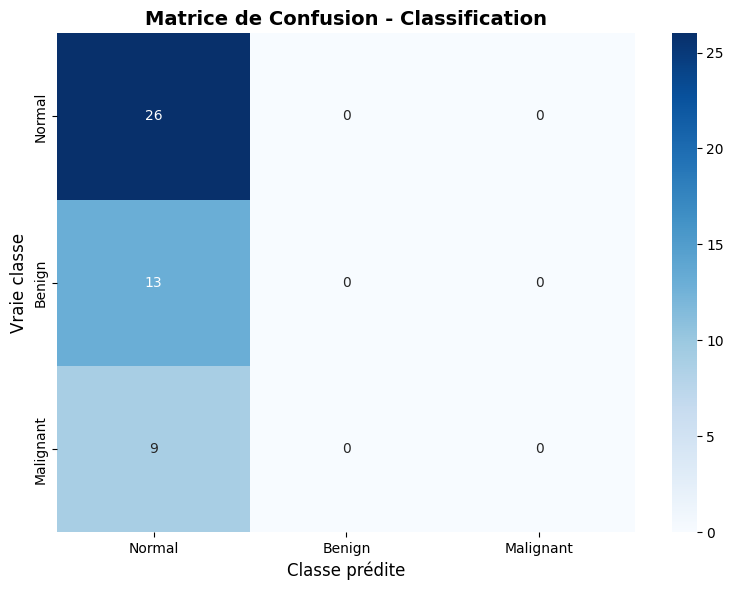

✅ Courbe ROC sauvegardée


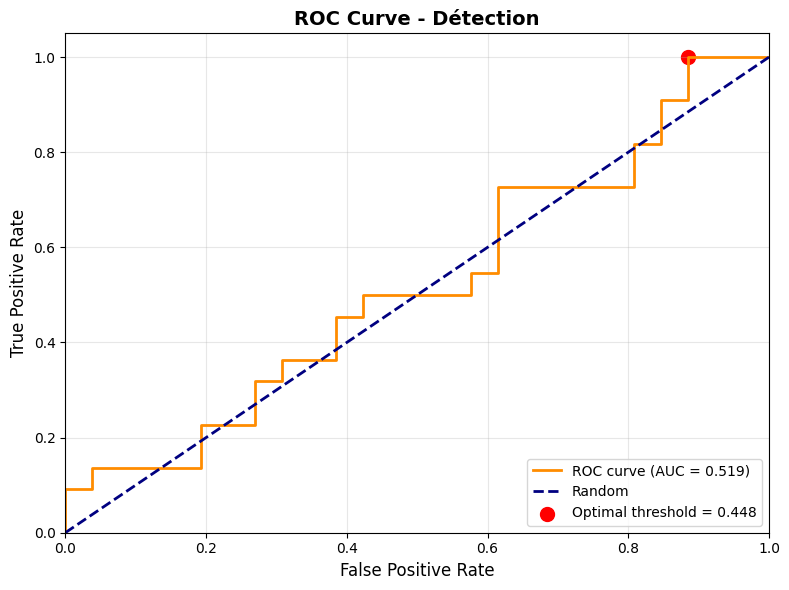


🎨 Génération des visualisations...
✅ Visualisation des prédictions sauvegardée


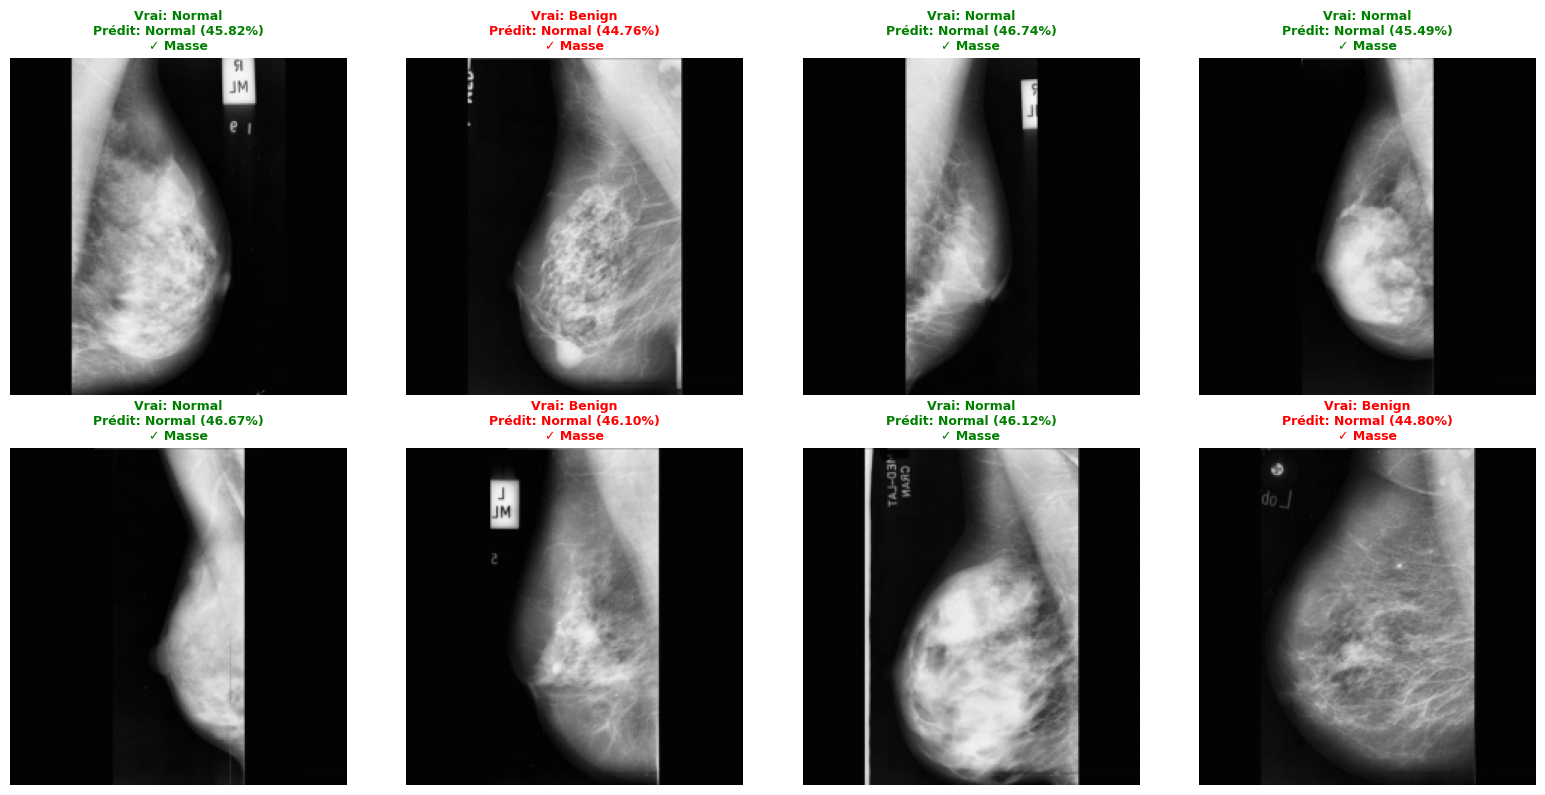


✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!
📁 Fichiers sauvegardés dans: /content/drive/MyDrive/MIAS/
   - multitask_model_final.h5
   - best_model_phase1.keras
   - best_model_phase2.keras
   - confusion_matrix.png
   - roc_curve.png
   - predictions_visualization.png
   - training_log_phase1.csv
   - training_log_phase2.csv


In [ ]:

# 1️ CONFIGURATION
IMG_SIZE = (224, 224)
NUM_CLASSES = 3  # 0: Normal, 1: Benign, 2: Malignant
BATCH_SIZE = 16  # Augmenté pour meilleure stabilité

# Chemins
base_dir = "/content/output/dataset_split_simple_2/"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")
csv_file = info_csv

# 2️ CHARGEMENT ET NETTOYAGE DU CSV

df = pd.read_csv(csv_file)
df['REFNUM'] = df['REFNUM'].str.strip()
df['label'] = df['label'].astype(int)

# Remplacer NaN par 0 pour images normales
df['X'] = df['X'].fillna(0).astype(float)
df['Y'] = df['Y'].fillna(0).astype(float)
df['RADIUS'] = df['RADIUS'].fillna(0).astype(float)

print(f"\n Distribution globale des labels:")
print(df['label'].value_counts().sort_index())
# 3️ FONCTION DE CHARGEMENT D'IMAGE

def load_image(img_path):

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Impossible de charger: {img_path}")

    img = img.astype(np.float32) / 255.0

    img = np.stack([img] * 3, axis=-1)

    return img


# 4️ DATA AUGMENTATION
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.85, 1.15],
    fill_mode='nearest'
)

# 5️ GÉNÉRATEUR MULTI-TASK
def generator(df_subset, split_name, augment=False):
    for _, row in df_subset.iterrows():
        img_name = row["REFNUM"] + ".png"
        img_path = os.path.join(base_dir, split_name, img_name)

        if not os.path.exists(img_path):
            continue

        try:
            img = load_image(img_path)
        except Exception as e:
            print(f"  Erreur chargement {img_path}: {e}")
            continue

        # Augmentation pour train uniquement
        if augment:
            img = train_datagen.random_transform(img)

        # TASK 1: Détection binaire
        label = int(row["label"])
        detection = 0.0 if label == 0 else 1.0

        # TASK 2: Classification multi-classe
        classification = tf.keras.utils.to_categorical(label, num_classes=NUM_CLASSES)

        # TASK 3: Localisation
        if detection == 1.0:
            # Normaliser par 1024 (taille originale MIAS)
            x = float(row['X']) / 1024.0
            y = float(row['Y']) / 1024.0
            r = float(row['RADIUS']) / 1024.0

            # Format: [x_center, y_center, width, height]
            localization = [x, y, 2*r, 2*r]
        else:
            localization = [0.0, 0.0, 0.0, 0.0]

        yield img, {
            "detection": np.array(detection, dtype=np.float32),
            "classification": np.array(classification, dtype=np.float32),
            "localization": np.array(localization, dtype=np.float32)
        }


# 6️ CRÉATION DES DATASETS TENSORFLOW
def create_dataset(df_subset, split_name, augment=False, shuffle=False, repeat=True):
    """Crée un tf.data.Dataset optimisé"""
    dataset = tf.data.Dataset.from_generator(
        lambda: generator(df_subset, split_name, augment=augment),
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            {
                "detection": tf.TensorSpec(shape=(), dtype=tf.float32),
                "classification": tf.TensorSpec(shape=(NUM_CLASSES,), dtype=tf.float32),
                "localization": tf.TensorSpec(shape=(4,), dtype=tf.float32)
            }
        )
    )

    if repeat:
        dataset = dataset.repeat()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Filtrer les DataFrames par split
train_files = [f.replace('.png', '') for f in os.listdir(train_dir) if f.endswith('.png')]
val_files = [f.replace('.png', '') for f in os.listdir(val_dir) if f.endswith('.png')]
test_files = [f.replace('.png', '') for f in os.listdir(test_dir) if f.endswith('.png')]

df_train = df[df["REFNUM"].isin(train_files)].reset_index(drop=True)
df_val = df[df["REFNUM"].isin(val_files)].reset_index(drop=True)
df_test = df[df["REFNUM"].isin(test_files)].reset_index(drop=True)

print(f"\n📈 Distribution des données:")
print(f"   Train: {len(df_train)} images")
print(df_train['label'].value_counts().sort_index())
print(f"\n   Validation: {len(df_val)} images")
print(df_val['label'].value_counts().sort_index())
print(f"\n   Test: {len(df_test)} images")
print(df_test['label'].value_counts().sort_index())

# Calculer le déséquilibre
train_normal = (df_train['label'] == 0).sum()
train_abnormal = (df_train['label'] != 0).sum()
print(f"\n  Ratio Normal/Anormal dans TRAIN: {train_normal}:{train_abnormal} ({train_normal/train_abnormal:.2f}:1)")

# 7️ VÉRIFICATION DES DONNÉES

print(" VÉRIFICATION DES GÉNÉRATEURS")


test_gen = generator(df_train.head(3), "train", augment=False)
for i, (img, labels) in enumerate(test_gen):
    print(f"\n Image {i+1}:")
    print(f"   Shape: {img.shape}, Range: [{img.min():.3f}, {img.max():.3f}]")
    print(f"   Detection: {labels['detection']}")
    print(f"   Classification: {np.argmax(labels['classification'])} ({CLASS_NAMES[np.argmax(labels['classification'])]})")
    print(f"   Localization: {labels['localization']}")
    if i >= 2:
        break

print("\n Génération des données validée")


# 8️ CRÉATION DES DATASETS
train_steps = max(1, len(df_train) // BATCH_SIZE)
val_steps = max(1, len(df_val) // BATCH_SIZE)
test_steps = max(1, len(df_test) // BATCH_SIZE)

print(f"\n Steps par epoch:")
print(f"   Train: {train_steps}")
print(f"   Validation: {val_steps}")
print(f"   Test: {test_steps}")

train_dataset = create_dataset(df_train, "train", augment=True, shuffle=True, repeat=True)
val_dataset = create_dataset(df_val, "val", augment=False, shuffle=False, repeat=True)
test_dataset = create_dataset(df_test, "test", augment=False, shuffle=False, repeat=False)


# 9️ FOCAL LOSS POUR DÉTECTION
def focal_loss(gamma=1.5, alpha=0.65):
    """
    Focal Loss pour classification binaire déséquilibrée

    Args:
        gamma: Facteur de modulation (1.5 = équilibré)
        alpha: Balance pos/neg (0.65 = légèrement vers positifs)
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)

        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)

        return tf.reduce_mean(weight * cross_entropy)

    return focal_loss_fixed


# 10 CALCUL DES POIDS DE CLASSES
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),
    y=df_train['label'].values
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print(f"\n  Poids de classes (balanced):")
for i, name in enumerate(CLASS_NAMES):
    print(f"   {name}: {class_weights[i]:.3f}")

# 1️1️ CONSTRUCTION DU MODÈLE
def build_multitask_model():
    inputs = layers.Input(shape=(224, 224, 3), name="input_image")

    # Backbone: ResNet50 pré-entraîné
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base_model.trainable = False  # Gelé pour Phase 1

    x = base_model(inputs, training=False)
    x = layers.Dropout(0.5, name="shared_dropout")(x)

    # HEAD 1: Détection binaire
    det = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001), name="det_dense1")(x)
    det = layers.Dropout(0.5, name="det_dropout1")(det)
    det = layers.Dense(64, activation="relu", name="det_dense2")(det)
    det = layers.Dropout(0.3, name="det_dropout2")(det)
    output_detection = layers.Dense(1, activation="sigmoid", name="detection")(det)

    # HEAD 2: Classification multi-classe
    cls = layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001), name="cls_dense1")(x)
    cls = layers.Dropout(0.5, name="cls_dropout1")(cls)
    cls = layers.Dense(64, activation="relu", name="cls_dense2")(cls)
    cls = layers.Dropout(0.3, name="cls_dropout2")(cls)
    output_classification = layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(cls)

    # HEAD 3: Localisation (bounding box)
    loc = layers.Dense(128, activation="relu", name="loc_dense1")(x)
    loc = layers.Dropout(0.4, name="loc_dropout")(loc)
    output_localization = layers.Dense(4, activation="sigmoid", name="localization")(loc)

    model = Model(
        inputs=inputs,
        outputs=[output_detection, output_classification, output_localization],
        name="MultiTask_MIAS_CNN"
    )

    return model, base_model


print("\n" + "=" * 70)
print("  CONSTRUCTION DU MODÈLE")
print("=" * 70)

model, base_model = build_multitask_model()
model.summary()

# 1️2️ COMPILATION AVEC FOCAL LOSS

losses = {
    "detection": focal_loss(gamma=1.5, alpha=0.65),
    "classification": "categorical_crossentropy",
    "localization": "mse"
}

loss_weights = {
    "detection": 1.5,       # Modéré
    "classification": 2.5,  # Priorité clinique
    "localization": 0.2     # Aide visuelle
}

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        "detection": [
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ],
        "classification": ["accuracy"],
        "localization": ["mae"]
    }
)

print("\n Modèle compilé avec Focal Loss (γ=1.5, α=0.65)")
# 1️3️ CALLBACKS
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_detection_auc',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_detection_auc',
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='/content/output/best_model_phase1.keras',
        monitor='val_detection_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    CSVLogger('/content/output/training_log_phase1.csv')
]


# 1️4️ PHASE 1: FEATURE EXTRACTION
print("\n" + "=" * 70)
print(" PHASE 1: FEATURE EXTRACTION (Backbone gelé)")
print("=" * 70)

history1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks_phase1,
    verbose=1
)

# 1️5️ PHASE 2: FINE-TUNING
print("\n" + "=" * 70)
print(" PHASE 2: FINE-TUNING (Dernières 50 couches dégelées)")
print("=" * 70)

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

print(f" Couches entraînables: {len([l for l in base_model.layers if l.trainable])}/50")

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        "detection": ["accuracy", tf.keras.metrics.AUC(name="auc"),
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")],
        "classification": ["accuracy"],
        "localization": ["mae"]
    }
)

callbacks_phase2 = [
    EarlyStopping(
        monitor='val_detection_auc',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_detection_auc',
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='/content/output/best_model_phase2.keras',
        monitor='val_detection_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    CSVLogger('/content/output/training_log_phase2.csv')
]

history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks_phase2,
    verbose=1
)



# 1️6️ ÉVALUATION SUR TEST SET
print("\n" + "=" * 70)
print(" ÉVALUATION FINALE SUR TEST SET")
print("=" * 70)

test_dataset_eval = create_dataset(df_test, "test", augment=False, shuffle=False, repeat=False)
results = model.evaluate(test_dataset_eval, steps=test_steps, verbose=1)

print("\n Résultats détaillés:")
for name, value in zip(model.metrics_names, results):
    print(f"   {name}: {value:.4f}")

# 1️7️ ANALYSE APPROFONDIE DES PRÉDICTIONS
print("\n" + "=" * 70)
print(" ANALYSE APPROFONDIE DES PRÉDICTIONS")
print("=" * 70)

# Récupérer toutes les prédictions
all_y_true_det = []
all_y_pred_det = []
all_y_true_class = []
all_y_pred_class = []
all_images = []

test_dataset_analysis = create_dataset(df_test, "test", augment=False, shuffle=False, repeat=False)

for images, labels in test_dataset_analysis.take(test_steps):
    predictions = model.predict(images, verbose=0)

    all_images.extend(images.numpy())
    all_y_true_det.extend(labels['detection'].numpy())
    all_y_pred_det.extend(predictions[0].flatten())
    all_y_true_class.extend(np.argmax(labels['classification'].numpy(), axis=1))
    all_y_pred_class.extend(np.argmax(predictions[1], axis=1))

all_y_true_det = np.array(all_y_true_det)
all_y_pred_det = np.array(all_y_pred_det)
all_y_true_class = np.array(all_y_true_class)
all_y_pred_class = np.array(all_y_pred_class)

# Distribution des probabilités
print(f"\n Distribution des probabilités de détection:")
print(f"   Min:    {all_y_pred_det.min():.4f}")
print(f"   Max:    {all_y_pred_det.max():.4f}")
print(f"   Mean:   {all_y_pred_det.mean():.4f}")
print(f"   Median: {np.median(all_y_pred_det):.4f}")

# Tester différents seuils
print(f"\n Performance à différents seuils:")
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_binary = (all_y_pred_det >= threshold).astype(int)

    if y_pred_binary.sum() > 0:
        prec = precision_score(all_y_true_det, y_pred_binary, zero_division=0)
        rec = recall_score(all_y_true_det, y_pred_binary, zero_division=0)
        f1 = f1_score(all_y_true_det, y_pred_binary, zero_division=0)
        print(f"   Seuil {threshold:.1f}: Prec={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")
    else:
        print(f"   Seuil {threshold:.1f}: Aucune détection")

# Trouver le seuil optimal
fpr, tpr, thresholds = roc_curve(all_y_true_det, all_y_pred_det)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\n SEUIL OPTIMAL : {optimal_threshold:.4f}")
y_pred_optimal = (all_y_pred_det >= optimal_threshold).astype(int)
prec_opt = precision_score(all_y_true_det, y_pred_optimal, zero_division=0)
rec_opt = recall_score(all_y_true_det, y_pred_optimal, zero_division=0)
f1_opt = f1_score(all_y_true_det, y_pred_optimal, zero_division=0)
print(f"   AUC-ROC:   {roc_auc:.4f}")
print(f"   Precision: {prec_opt:.4f}")
print(f"   Recall:    {rec_opt:.4f}")
print(f"   F1-Score:  {f1_opt:.4f}")

# Matrice de confusion pour classification
print(f"\n Classification Report:")
print(classification_report(all_y_true_class, all_y_pred_class,
                           target_names=CLASS_NAMES, zero_division=0))

cm = confusion_matrix(all_y_true_class, all_y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Matrice de Confusion - Classification', fontweight='bold', fontsize=14)
plt.ylabel('Vraie classe', fontsize=12)
plt.xlabel('Classe prédite', fontsize=12)
plt.tight_layout()
plt.show()

# Courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100,
            label=f'Optimal threshold = {optimal_threshold:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Détection', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 1️8️ VISUALISATION DES PRÉDICTIONS
print("\n Génération des visualisations...")

num_samples = min(8, len(all_images))
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(num_samples):
    ax = axes[i]
    img = all_images[i]

    has_mass = all_y_pred_det[i] > optimal_threshold
    true_class = CLASS_NAMES[all_y_true_class[i]]
    pred_class = CLASS_NAMES[all_y_pred_class[i]]
    confidence = all_y_pred_det[i]

    ax.imshow(img)

    # Titre avec prédiction
    title = f"Vrai: {true_class}\n"
    title += f"Prédit: {pred_class} ({confidence:.2%})\n"
    title += f"{'✓ Masse' if has_mass else '✗ Normal'}"

    color = 'green' if true_class == pred_class else 'red'
    ax.set_title(title, fontsize=9, fontweight='bold', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

# 1️9️ SAUVEGARDER LE MODÈLE FINAL
model.save("/content/output/multitask_model_final.h5")
print(f"\n{'='*70}")
print("ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
print(f"{'='*70}")
print(f" Fichiers sauvegardés dans: /content/output/")
print(f"   - multitask_model_final.h5")
print(f"   - best_model_phase1.keras")
print(f"   - best_model_phase2.keras")
print(f"   - training_log_phase1.csv")
print(f"   - training_log_phase2.csv")
print(f"{'='*70}")